<a href="https://colab.research.google.com/github/telecombcn-dl/2018-dlai-team2/blob/master/variational_autoencoder_anime_dataset_latdim=2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder (VAE) on on Anime Characters dataset (latent_dim = 2)**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from keras import backend as K

from google.colab import files

import cv2

import copy

import random

Using TensorFlow backend.


download data set and classify training data (x_train) and validation data (x_val)

In [0]:
!wget http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
!unzip -qq animeface-character-dataset.zip

--2018-12-05 18:56:15--  http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
Resolving www.nurs.or.jp (www.nurs.or.jp)... 54.187.126.238
Connecting to www.nurs.or.jp (www.nurs.or.jp)|54.187.126.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592335393 (565M) [application/zip]
Saving to: ‘animeface-character-dataset.zip.1’

animeface-character 100%[===================>] 564.89M  21.5MB/s    in 30s     

2018-12-05 18:56:46 (18.7 MB/s) - ‘animeface-character-dataset.zip.1’ saved [592335393/592335393]

replace animeface-character-dataset/index.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
x_train = []
x_val = []


directories = os.listdir('animeface-character-dataset/thumb/')
for directory in directories:
  dir_path = 'animeface-character-dataset/thumb/'+directory
  num_fil = 0
  num_train = 0
  num_val = 0
  if os.path.isdir(dir_path):
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        num_fil += 1
    num_train = int(round(num_fil*0.7))
    num_val = int(round((num_fil-num_train)*0.5))
    i = 0
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        filepath = dir_path+"/"+filename
        if i<num_train:
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_train.append(img)
        elif i<(num_train+num_val):
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_val.append(img)
        i += 1
x_train = np.array(x_train)
x_val = np.array(x_val)


In [0]:
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_val = x_val.astype('float32') / max_value


size change

In [0]:
x_train = np.reshape(x_train, (len(x_train), 64, 64, 3))
x_val = np.reshape(x_val, (len(x_val), 64, 64, 3))


Varaiational AutoEncoder model with fuly connected network

In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# CNN
# network parameters
input_shape = (64, 64, 3)
latent_dim = 2

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(16, (3, 3),activation='relu', strides=2, padding='same')(x)
x = Conv2D(32, (3, 3),activation='relu', strides=2, padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', strides=2, padding='same')(x)

outputs = Conv2DTranspose(filters=3, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   4640        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 8192)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

define a loss function.

In [0]:
models = (encoder, decoder)
image_size = 64
# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')


Train the neural network.

In [0]:
vae.fit(x_train,
        epochs=100,
        batch_size=128,
        validation_data=(x_val, None),
        verbose=2)

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
 - 6s - loss: 2643.8556 - val_loss: 2565.4288
Epoch 2/100
 - 4s - loss: 2539.3897 - val_loss: 2568.0309
Epoch 3/100
 - 4s - loss: 2507.0034 - val_loss: 2504.2753
Epoch 4/100
 - 4s - loss: 2489.8314 - val_loss: 2521.9978
Epoch 5/100
 - 4s - loss: 2482.0694 - val_loss: 2490.8068
Epoch 6/100
 - 4s - loss: 2475.8307 - val_loss: 2499.2235
Epoch 7/100
 - 4s - loss: 2470.5351 - val_loss: 2500.0255
Epoch 8/100
 - 4s - loss: 2467.4478 - val_loss: 2482.1491
Epoch 9/100
 - 4s - loss: 2464.8135 - val_loss: 2481.5781
Epoch 10/100
 - 4s - loss: 2461.3741 - val_loss: 2488.4876
Epoch 11/100
 - 4s - loss: 2461.2552 - val_loss: 2459.8829
Epoch 12/100
 - 4s - loss: 2457.6898 - val_loss: 2463.1354
Epoch 13/100
 - 4s - loss: 2456.8933 - val_loss: 2464.9112
Epoch 14/100
 - 4s - loss: 2453.4252 - val_loss: 2480.5655
Epoch 15/100
 - 4s - loss: 2451.7223 - val_loss: 2457.7057
Epoch 16/100
 - 4s - loss: 2450.6216 - val_loss: 2469.0004
Epoch 17/100
 - 

Visualizations

Images generated by VAE from random noise

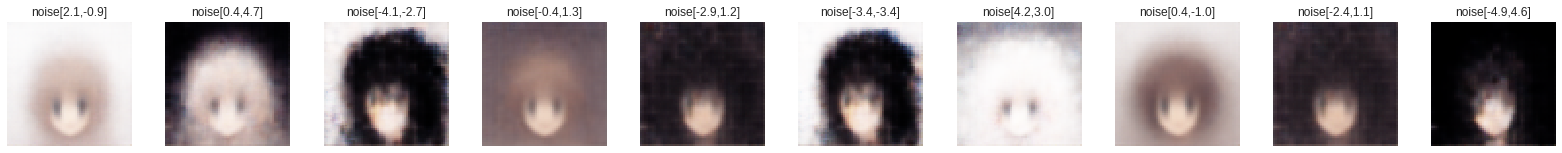

In [0]:
# Plot 10 examples when feeding the decoder with random samples from the 
# latent 2-dimensional space
n = 10

plt.figure(figsize=(22, 5))
for i in range(1,n+1):
    # Generate a random sample with values between -5.0 and 5.0
    z_sample = np.array([[random.randint(-50,50)/10, random.randint(-50,50)/10]])
    # Feed decoder
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(64, 64, 3)
    
    # Plot one example
    ax = plt.subplot(1, n, i)
    plt.tight_layout()
    plt.imshow(digit)
    plt.title("noise[%.1f,%.1f]" %(z_sample[0,0], z_sample[0,1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

